GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 820 K  | train
-------------------------------------------------------------
814 K     Trainable params
6.2 K     Non-trainable params
820 K     Total params
3.281     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

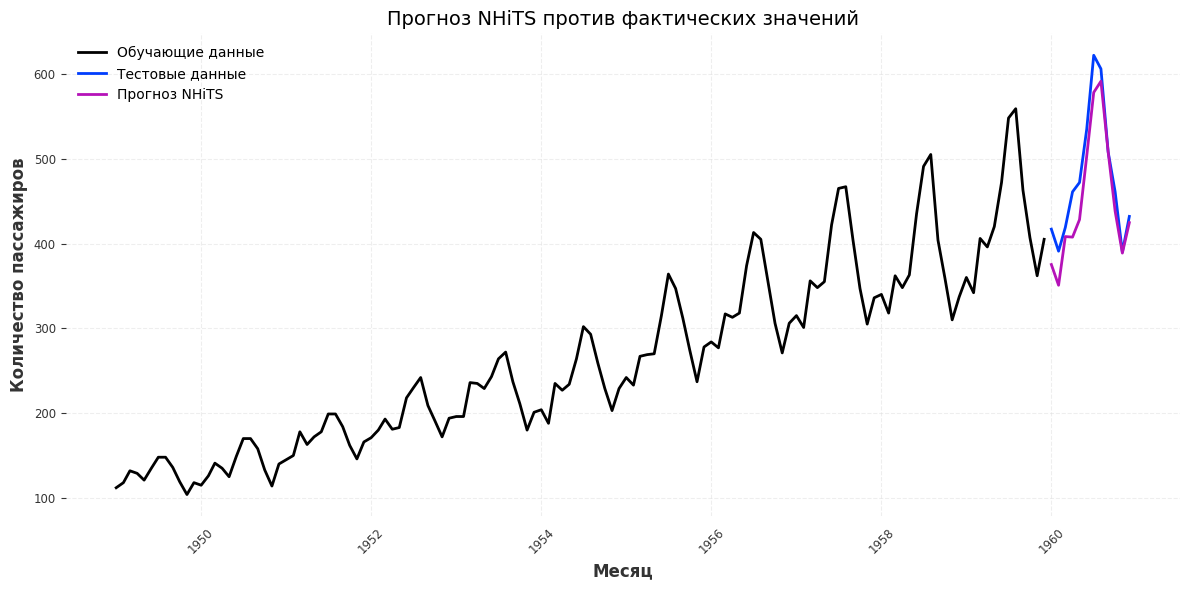

Среднеквадратичная ошибка NHiTS: 31.57


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_squared_error

# Загрузка данных
data = pd.read_csv('AirPassengers.csv')  # Замените на путь к вашему файлу
data["Month"] = pd.to_datetime(data["Month"]).dt.to_period("M").dt.to_timestamp()

# Определяем последний год для тестовой выборки
last_year = data["Month"].dt.year.max()

# Разделение данных: тренировочные и тестовые
train_data = data[data["Month"].dt.year < last_year]
test_data = data[data["Month"].dt.year == last_year]

# Подготовка временного ряда для Darts
train_series = TimeSeries.from_dataframe(train_data, time_col='Month', value_cols='#Passengers')
test_series = TimeSeries.from_dataframe(test_data, time_col='Month', value_cols='#Passengers')

# Масштабирование тренировочных данных
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train_series)

# Инициализация модели NHiTS
nhits_model = NHiTSModel(
    input_chunk_length=12,      # Длина входного окна
    output_chunk_length=12,     # Длина выходного окна
    n_epochs=100,                # Количество эпох обучения
    random_state=42,             # Установка случайного состояния для воспроизводимости
    dropout=0.05
)

# Обучение модели
nhits_model.fit(scaled_train)

# Прогнозирование на 12 месяцев вперед
forecast = nhits_model.predict(n=12)

# Обратное преобразование для получения оригинальных значений
forecast = train_scaler.inverse_transform(forecast)

# Визуализация результатов
plt.figure(figsize=(12, 6))
train_series.plot(label='Обучающие данные', lw=2)
test_series.plot(label='Тестовые данные', lw=2)
forecast.plot(label='Прогноз NHiTS', lw=2)

# Добавление заголовка и подписей к осям
plt.title("Прогноз NHiTS против фактических значений", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("Количество пассажиров", fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()

# Вычисление RMSE для NHiTS
nhits_rmse = np.sqrt(mean_squared_error(test_data["#Passengers"], forecast.values()))
print(f"Среднеквадратичная ошибка NHiTS: {nhits_rmse:.2f}")
